<a href="https://colab.research.google.com/github/pandyajaimin/Z_work/blob/main/a4_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file is for time series forecastin and backtesting

# Import Libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import glob
import math
from random import randint
import datetime
import warnings
warnings.simplefilter("ignore", UserWarning)

#Dataset

## Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip the data

In [ ]:
!mkdir data
!unzip /content/drive/MyDrive/modelparams.zip -d data

##Merge files

Assume single continous data  
Only spot will be used for analysis

In [ ]:
file_path = "data"
file_list = sorted([os.path.join(file_path, fname) for fname in os.listdir(file_path)])
df_full = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)
df = df_full[['Spot']]
df_full.reset_index(drop=True)
print(df.head())
print(df.info())

Here is the evolution of a few features over time:

##Visualize

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f98a02e0c70>],
      dtype=object)

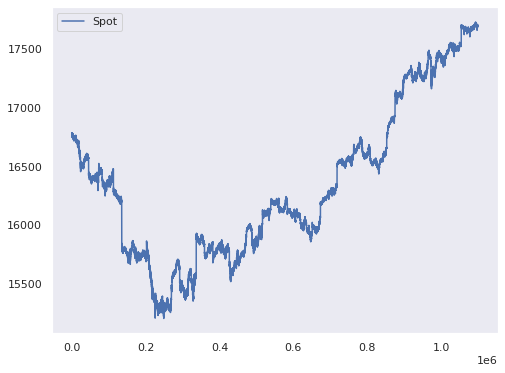

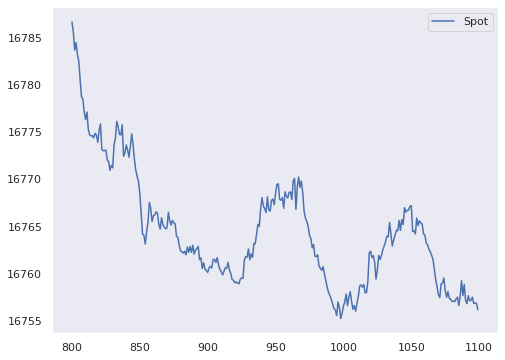

In [5]:
plot_features = df
plot_features.plot(subplots=True)
plot_features = df[800:1100]
plot_features.plot(subplots=True)

##Return value

Log return will be used for analysis
*   Change is important instead of absolute value
*   Helpful for standardization

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f98a021fcd0>],
      dtype=object)

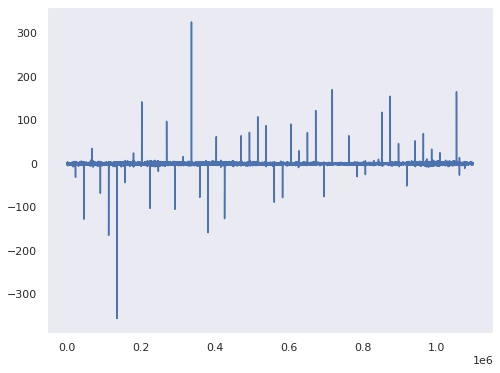

In [6]:
pd.options.mode.chained_assignment = None 
df.loc[:,'ch_return'] = df_full['Spot'].diff()
plot_features = df['ch_return']
plot_features.plot(subplots=True)

##Concept for output

Model concept:  
input: Previous 240 second  
output: Decision based on next 60 second

In [7]:
df.head()

,Spot,ch_return
0,16783.167168,NaN
1,16781.622222,-1.544946
2,16781.787766,0.165544
3,16781.526735,-0.261031
4,16781.380592,-0.146143


In [ ]:
# df.loc[:,'Value'] = df['ch_return']*df['Vol']
# plot_features = df['Value']
# plot_features.plot(subplots=True)
# plt.figure()
# plot_features = df['Value'][800:1100]
# plot_features.plot(subplots=True)

In [8]:
next_value = 60
print(df.head(6), df.tail(6))
df['next_max'] = df['Spot'].rolling(next_value).max().shift(-next_value)
df['next_min'] = df['Spot'].rolling(next_value).min().shift(-next_value)
df['d_max'] = df['Spot'].rolling(next_value).max().shift(-next_value)-df['Spot']
df['d_min'] = df['Spot']-df['Spot'].rolling(next_value).min().shift(-next_value)
df['R'] = df['d_max']-df['d_min']
print(df.head(6), df.tail(6))
df = df.iloc[1:-next_value,:].reset_index(drop=True)
print(df.head(6), df.tail(6))

           Spot  ch_return
0  16783.167168        NaN
1  16781.622222  -1.544946
2  16781.787766   0.165544
3  16781.526735  -0.261031
4  16781.380592  -0.146143
5  16781.426866   0.046274                  Spot  ch_return
1099603  17697.566559   0.263121
1099604  17697.754575   0.188016
1099605  17697.865545   0.110970
1099606  17698.186613   0.321068
1099607  17698.283514   0.096901
1099608  17698.231108  -0.052406
           Spot  ch_return      next_max      next_min     d_max      d_min  \
0  16783.167168        NaN  16786.333403  16772.227839  3.166235  10.939329   
1  16781.622222  -1.544946  16786.333403  16772.227839  4.711181   9.394383   
2  16781.787766   0.165544  16786.333403  16772.227839  4.545637   9.559927   
3  16781.526735  -0.261031  16786.333403  16772.227839  4.806668   9.298896   
4  16781.380592  -0.146143  16786.333403  16772.227839  4.952811   9.152753   
5  16781.426866   0.046274  16786.333403  16772.227839  4.906537   9.199027   

          R  
0 -7.773094 

##Normal distribution

Next, look at the statistics of the dataset:

*   Remove Noise (Due to low signal/noise value exact value prediction will not be accurate)
*   Blanced dataset (25,25,25,25)



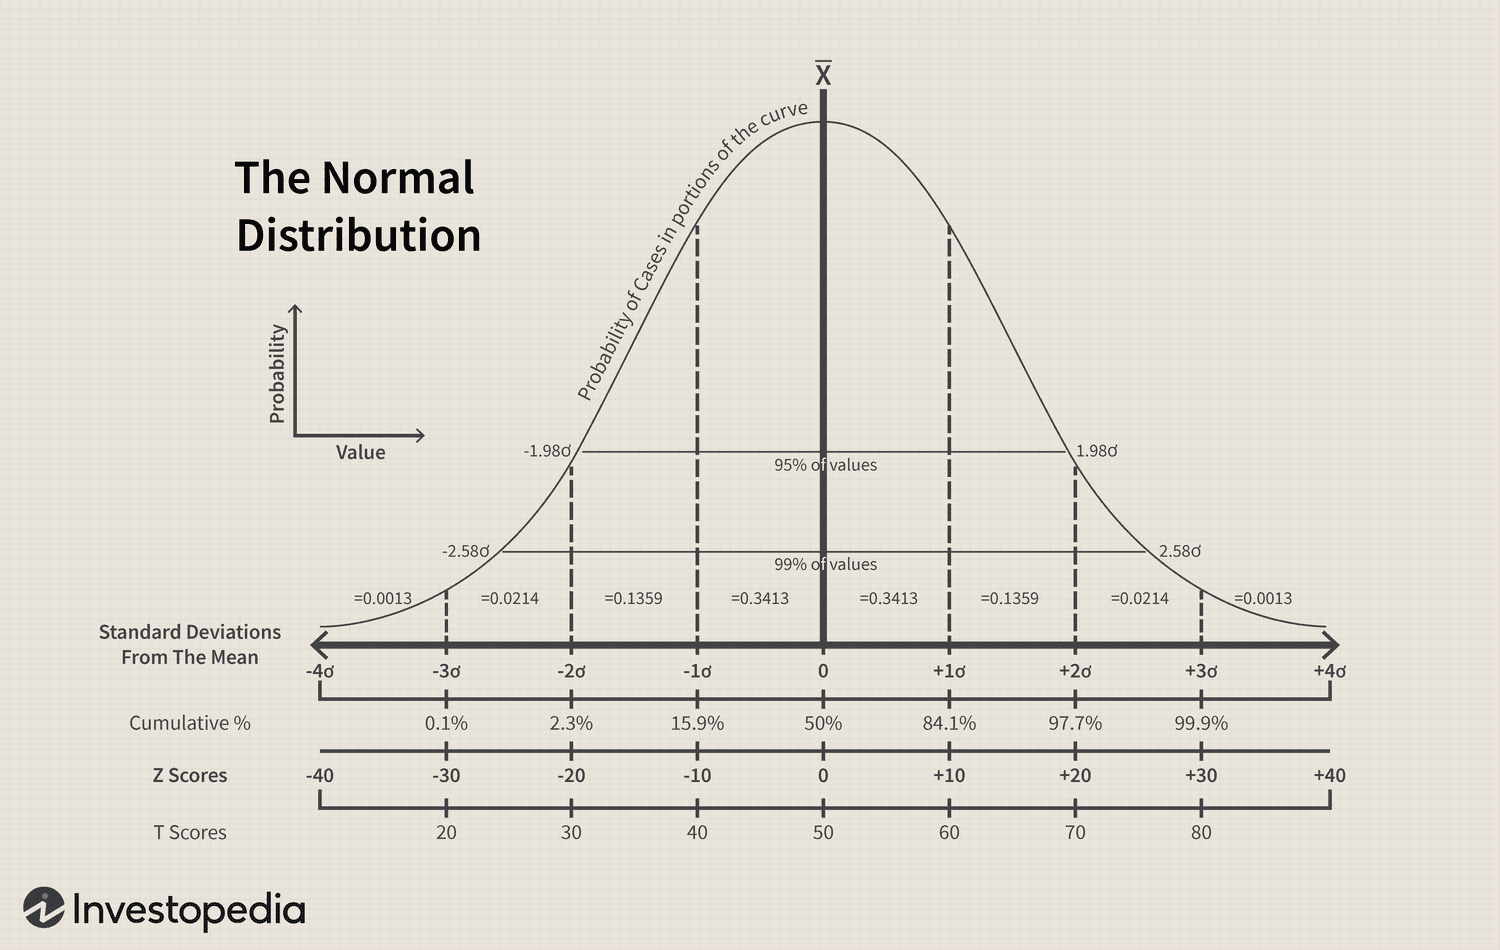

In [9]:
# df = df[['log_return','next_sum']]
perc =[0.001, 0.023, 0.159, 0.20, 0.25, 0.33, 0.50, 0.66, 0.75, 0.80, 0.841, 0.977, 0.999]
df.describe(percentiles = perc).transpose()

,count,mean,std,min,0.1%,2.3%,15.9%,20%,25%,33%,50%,66%,75%,80%,84.1%,97.7%,99.9%,max
Spot,1099548.0,16341.150992,661.046385,15203.301575,15238.672658,15309.307528,15726.187633,15757.598400,15795.322787,15916.673343,16219.516041,16543.862833,16676.943385,17100.087421,17270.987131,17679.250585,17717.457329,17733.690867
ch_return,1099548.0,0.000833,1.034401,-356.019787,-3.458741,-1.591321,-0.572736,-0.457769,-0.346743,-0.209855,-0.002749,0.190756,0.345741,0.458760,0.575926,1.597714,3.541428,326.143683
next_max,1099548.0,16345.249168,660.579439,15218.264805,15246.038094,15315.499014,15730.541343,15761.469159,15799.607631,15920.945158,16222.803944,16546.362764,16680.902639,17105.216511,17274.383676,17681.779829,17719.609044,17733.690867
next_min,1099548.0,16337.172519,661.517632,15203.301575,15230.098082,15302.366926,15722.117529,15753.548985,15791.199252,15911.812133,16216.545034,16541.346685,16674.319522,17096.123356,17267.289205,17677.046404,17715.463086,17728.971532
d_max,1099548.0,4.098176,5.992977,-356.019787,-2.172750,-0.567947,0.441794,0.692376,1.014176,1.560252,2.888386,4.485570,5.689007,6.544786,7.408766,15.493566,61.755532,336.270115
d_min,1099548.0,3.978472,5.687763,-322.929373,-2.225494,-0.570587,0.468698,0.721421,1.043190,1.584076,2.856029,4.362383,5.504295,6.327970,7.178018,15.087292,40.222550,372.891621
R,1099548.0,0.119703,9.212121,-727.359928,-39.860452,-14.381619,-6.041728,-5.055140,-4.057112,-2.674500,0.023068,2.614531,4.226740,5.261110,6.263314,14.732103,61.711602,659.081853


Sell (<-2.67)  
Hold (-2.67 < x < 2.61)  
Buy (>2.61)  

##Visualize classification

539014
-10.379299000000174
Sell


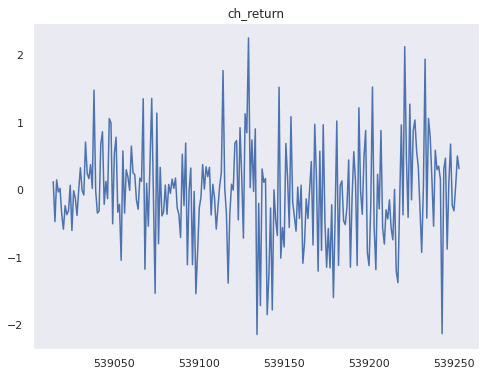

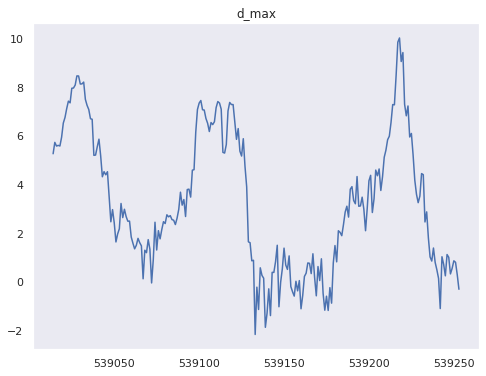

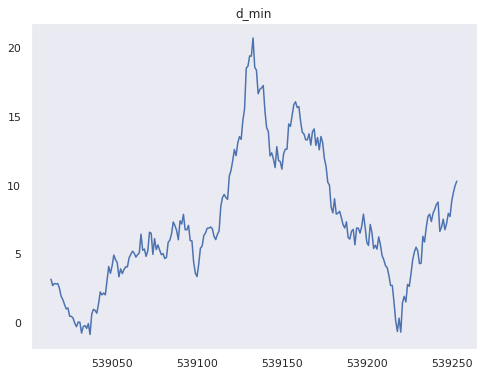

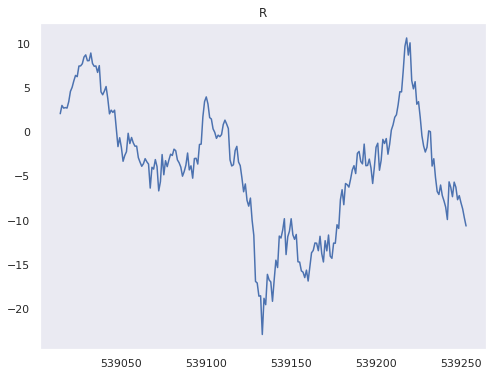

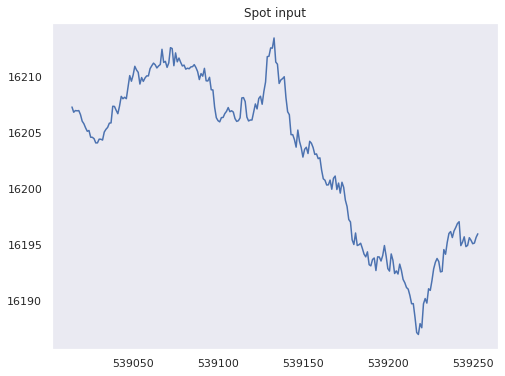

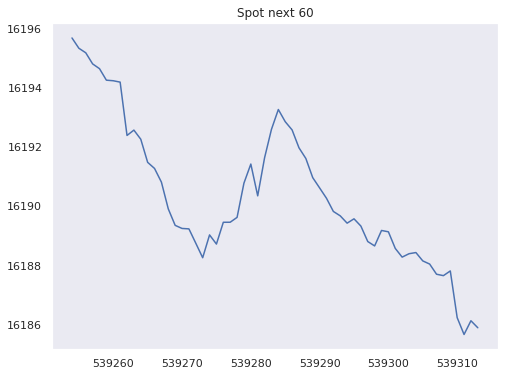

In [12]:
x = randint(0, 1000000)
print(x)
plot_features = df['ch_return'][x:x+240]
_ = plot_features.plot(); plt.title('ch_return')
plt.figure()
plot_features = df['d_max'][x:x+240]
_ = plot_features.plot(); plt.title('d_max')
plt.figure()
plot_features = df['d_min'][x:x+240]
_ = plot_features.plot(); plt.title('d_min')
plt.figure()
plot_features = df['R'][x:x+240]
_ = plot_features.plot(); plt.title('R')
plt.figure()
plot_features = df['Spot'][x:x+240]; plt.title('Spot input')
_ = plot_features.plot()
plt.figure()
plot_features = df['Spot'][x+240:x+300]; plt.title('Spot next 60')
ax = plot_features.plot()
ax.get_yaxis().get_major_formatter().set_scientific(False)

R = df['R'][x+240]

print(R)
if R > 0:
  print("Buy")
else:
  print("Sell")

##Create output columns

In [ ]:
# df['Sell'] = np.where(df['R'] <= -2.67, 1, 0)
# df['Hold'] = np.where((df['R'] > -2.67) & (df['R'] <= 2.61), 1, 0)
df['Buy'] = np.where(df['R'] > 0, 1, 0)

# df['Category'] = np.argmax(np.array(df[['Sell','Hold','Buy']]), axis = 1)
print(df.head(25),'\n\n', df.tail(25))

Text(0.5, 1.0, 'Buy')

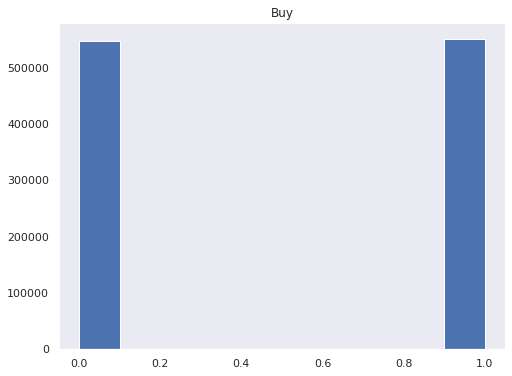

In [14]:
plt.hist(df['Buy']); plt.title('Buy')
# plt.figure()
# plt.hist(df['Sell']); plt.figure('Sell')
# plt.figure()
# plt.hist(df['Hold']); plt.figure('Hold')

## Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [15]:
df = df[['Spot','ch_return','Buy']]
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)].reset_index(drop=True)
val_df = df[int(n*0.7):int(n*0.9)].reset_index(drop=True)
test_df = df[int(n*0.9):].reset_index(drop=True)

In [16]:
print(len(df),len(train_df),len(val_df),len(test_df))

1099548 769683 219910 109955


## Standardization

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [17]:
train_mean = train_df['ch_return'].mean()
train_std = train_df['ch_return'].std()
print(train_mean, train_std)

train_df['ch_return'] = (train_df['ch_return'] - train_mean) / train_std
val_df['ch_return'] = (val_df['ch_return'] - train_mean) / train_std
test_df['ch_return'] = (test_df['ch_return'] - train_mean) / train_std

-0.00019546072084221516 1.1078667541511187


### Before the standardization

In [18]:
print(train_mean, train_std)

-0.00019546072084221516 1.1078667541511187


### After the standardization

In [19]:
print(train_df['ch_return'].mean(), train_df['ch_return'].std(), train_df['ch_return'].max())

4.588119260432799e-18 1.0 294.38908355962053


###Visualize the standardize value

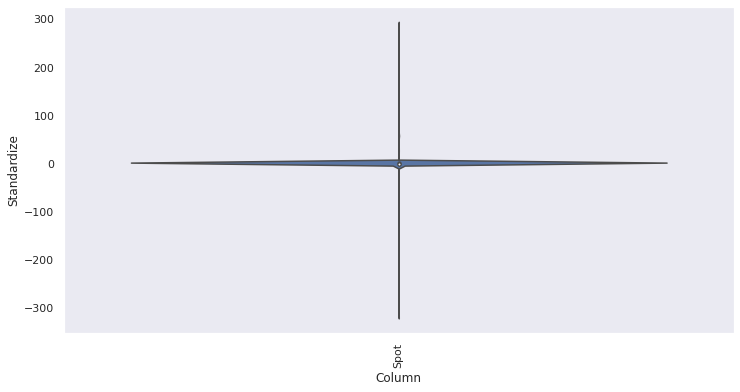

In [20]:
df_std = pd.DataFrame((df['ch_return'] - train_mean) / train_std)
df_std = df_std.melt(var_name='Column', value_name='Standardize')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Standardize', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

#Data Generator

In [21]:
batch_size = 16
input_width = 240
label_width = 1
shift = 0
g_input_columns=['Value']
g_label_columns=['Buy']

In [22]:
class DataGen(tf.keras.utils.Sequence):    
    def __init__(self, df, batch_size, input_width, 
                 input_columns=None, label_columns=None):
      self.df = df
      self.batch_size = batch_size
      self.input_width = input_width
      self.shift = shift
      self.input_columns = input_columns
      self.label_columns = label_columns
      self.n = len(self.df)-self.input_width
      # print(self.n)
    
    def __len__(self):
      return self.n // self.batch_size
    
    def __getitem__(self, index):
      i = index * self.batch_size;
      # batches = self.df[i+self.input_width:i + self.input_width + self.batch_size].reset_index();
      X = np.zeros((self.batch_size,) + (self.input_width,) + (len(self.input_columns),), dtype="float32");
      y = np.zeros((self.batch_size,) + (len(self.label_columns),), dtype="float32");
      # print(i, index)
      # print(X.shape, y.shape)
      for j in range(batch_size):
        # print(i,j,i+j+self.input_width)
        X[j,:,:] = self.df.loc[i+j: i+j+self.input_width-1, ['ch_return']]
        y[j,:] = self.df.loc[i+j+self.input_width-1, ['Buy']]
      return X, y

In [23]:
train_gen = DataGen(train_df, batch_size, input_width, 
                    g_input_columns, g_label_columns)
val_gen = DataGen(val_df, batch_size, input_width, 
                    g_input_columns, g_label_columns)
test_gen = DataGen(test_df, batch_size, input_width, 
                    g_input_columns, g_label_columns)
print('done!')

done!


28894 6
3055 6
1098 12


Text(0.5, 1.0, '[1.]')

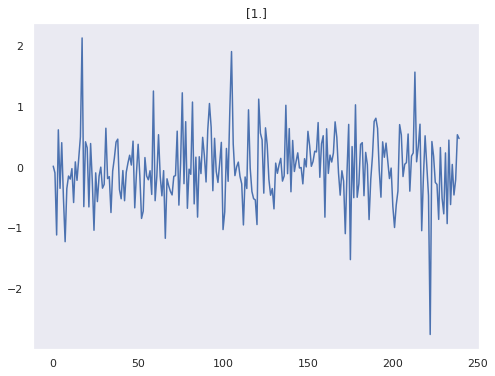

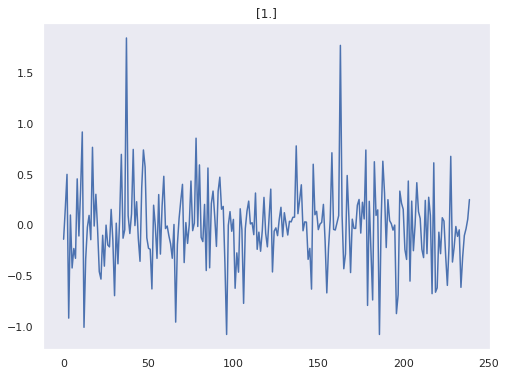

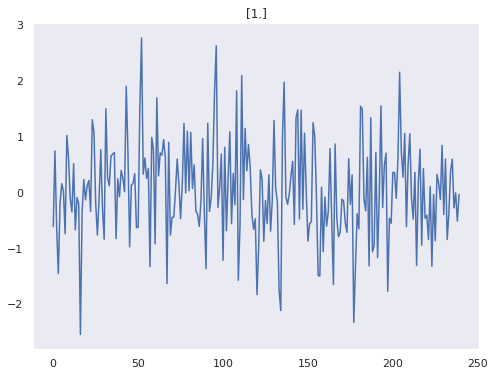

In [34]:
n1 = randint(0, int((len(df)-input_width)*0.7/batch_size-1))
n2 = randint(0, batch_size-1)
print(n1,n2)
# n1 = 0
# n2 = 18
temp_X = train_gen[n1][0][n2]
temp_y = train_gen[n1][1][n2]
plt.figure()
plt.plot(temp_X); plt.title(str(temp_y))

n1 = randint(0, int((len(df)-input_width)*0.2/batch_size-1))
n2 = randint(0, batch_size-1)
print(n1,n2)
# n1 = 0
# n2 = 18
temp_X = val_gen[n1][0][n2]
temp_y = val_gen[n1][1][n2]
plt.figure()
plt.plot(temp_X); plt.title(str(temp_y))

n1 = randint(0, int((len(df)-input_width)*0.1/batch_size-1))
n2 = randint(0, batch_size-1)
print(n1,n2)
# n1 = 0
# n2 = 18
temp_X = test_gen[n1][0][n2]
temp_y = test_gen[n1][1][n2]
plt.figure()
plt.plot(temp_X); plt.title(str(temp_y))

#Model

In [35]:
from keras import layers
from keras.models import Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 240, 16)           128       
                                                                 
 average_pooling1d_2 (Averag  (None, 60, 16)           0         
 ePooling1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 x2 (Dense)                  (None, 16)                15376     
                                                                 
 output (Dense)              (None, 1)                 17        
                                                           

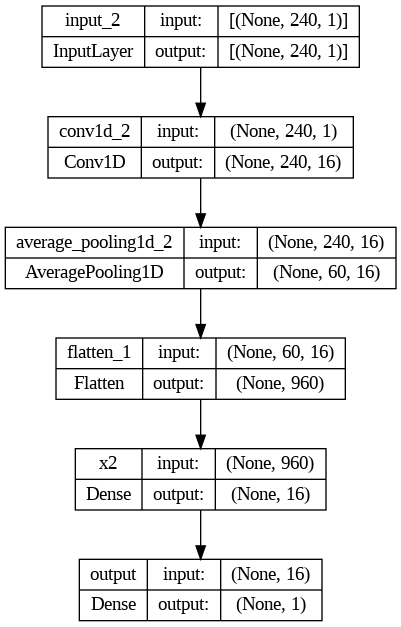

In [93]:
inputs = tf.keras.layers.Input((input_width, label_width))

c1 = tf.keras.layers.Conv1D(filters=16, kernel_size=(7,), padding='same')(inputs)
p1 = tf.keras.layers.AveragePooling1D(pool_size=4)(c1)

# c2 = tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), padding='same')(p1)
# p2 = tf.keras.layers.AveragePooling1D(pool_size=8)(c2)

# c3 = tf.keras.layers.Conv1D(filters=64, kernel_size=(7,), activation='relu', padding='same')(p2)
# p3 = tf.keras.layers.AveragePooling1D(pool_size=8)(c3)

x1 = tf.keras.layers.Flatten()(p1)

x2 = layers.Dense(16, name='x2')(x1)
# x2 = layers.Dropout(.1)(x2)

# x3 = layers.Dense(64, activation = 'relu', name='x3')(x2)
# x3 = layers.Dropout(.1)(x3)

# x4 = layers.Dense(16, activation = 'relu', name='x4')(x2)
# x4 = layers.Dropout(.1)(x4)

outputs = layers.Dense(1,name='output')(x2)

model = Model(inputs= inputs, outputs=outputs)

model.compile(tf.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy())
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True ,show_layer_names=True,)

##Model training

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('./v4_best.h5', verbose=0, save_weights_only=True, save_best_only=True)]
history1 = model.fit(train_gen, epochs = 1, validation_data=val_gen, initial_epoch = 0, callbacks=callbacks)
# model.save_weights('./v1_last.h5')

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('./v5_best.h5', verbose=0, save_weights_only=True, save_best_only=True)]
history1 = model.fit(train_gen, epochs = 3, validation_data=val_gen, initial_epoch = 1, callbacks=callbacks)
# model.save_weights('./v1_last.h5')

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('./v6_best.h5', verbose=0, save_weights_only=True, save_best_only=True)]
history1 = model.fit(train_gen, epochs = 3, validation_data=val_gen, initial_epoch = 2, callbacks=callbacks)
# model.save_weights('./v1_last.h5')

In [ ]:
model.fit(train_gen, epochs = 1, validation_data=val_gen, initial_epoch = 0)
model.save_weights('./v1_best.h5')

In [183]:
model.fit(train_gen, epochs = 2, validation_data=val_gen, initial_epoch = 1)
model.save_weights('./v2_best.h5')

Epoch 2/2
48090/48090 [==============================] - 1471s 31ms/step - loss: 0.6977 - val_loss: 0.6944


In [253]:
model.fit(train_gen, epochs = 3, validation_data=val_gen, initial_epoch = 2)
model.save_weights('./v3_best.h5')

Epoch 3/3
48090/48090 [==============================] - 1490s 31ms/step - loss: 0.6979 - val_loss: 0.6931


##Model save

In [ ]:
model = tf.keras.models.load_model("/content/v11.h5")

In [276]:
model.load_weights('/content/v19J_w.h5')

In [121]:
model.save('./v19J.h5')

##Model training plot

In [ ]:
mpl.rcParams['figure.figsize'] = (9,6);
plt.figure()
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

#Model testing 

##On one 

24024 12
[0.]
1/1 [==============================] - 0s 18ms/step
predicted
0.5201122
Buy


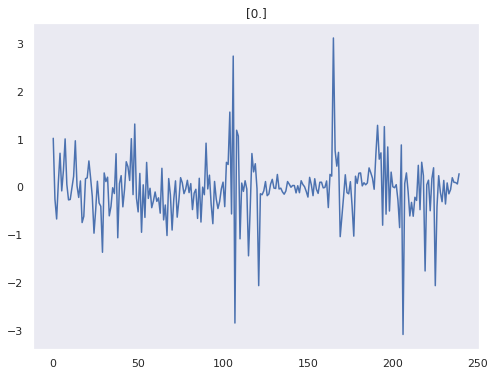

In [254]:
n1 = randint(0, int((len(df)-input_width)*0.7/batch_size-1))
n2 = randint(0, batch_size-1)
print(n1,n2)
temp_X = train_gen[n1][0][n2]
temp_y = train_gen[n1][1][n2]
plt.figure()
plt.plot(temp_X); plt.title(str(temp_y))
print(str(temp_y))

# ans = np.argmax(temp_y)
# print(ans)
# if ans == 0:
#   print("Sell")
# # elif ans== 1:
# #   print("Hold")
# # elif ans== 2:
# #   print("Buy")
# else:
#   print("Buy")

yp1 = model.predict(np.expand_dims(temp_X,axis=0))
print('predicted')
print(yp1[0][0])
# yp1 = yp[0][0:7] * (min_max_scaler_1.data_max_ - min_max_scaler_1.data_min_) + min_max_scaler_1.data_min_
ans = round(yp1[0][0])
# print(ans)
if ans == 0:
  print("Sell")
# # elif ans== 1:
# #   print("Hold")
# # elif ans== 2:
# #   print("Buy")
else:
  print("Buy")

##Model evaluation

In [ ]:
results = model.evaluate(test_gen)
print(results)

In [54]:
from tqdm import tqdm

##Results of test dataset

In [331]:
n = len(test_df)-input_width
leng = n//batch_size
bt = np.zeros((batch_size*leng,3));
# print(np.shape(bt))
for n1 in tqdm(range(0, int((len(df)-240)*0.1/batch_size)-15)):
# for n1 in tqdm(range(0, int((len(df)-240)*0.1/batch_size)-6700)):
  temp_X = test_gen[n1][0]
  temp_y = test_gen[n1][1]
  yp1 = model.predict(temp_X, verbose=0)
  # print(np.shape(temp_X))
  bt[n1*batch_size:(n1+1)*batch_size,0] = temp_X[:,-1,0]
  # bt[n1*batch_size:(n1+1)*batch_size,1] = np.argmax(temp_y, axis = 1)
  bt[n1*batch_size:(n1+1)*batch_size,1] =round(temp_y[0][0])
  # bt[n1*batch_size:(n1+1)*batch_size,2] = np.argmax(yp1, axis = 1)
  bt[n1*batch_size:(n1+1)*batch_size,2] =yp1[0][0]
  # bt[n1*batch_size:(n1+1)*batch_size,2:] = yp1
  

100%|██████████| 6855/6855 [10:11<00:00, 11.20it/s]


In [332]:
bt_df = pd.DataFrame(bt[:,:(int((len(df)-240)*0.1/batch_size)-15)*batch_size])
bt = bt[0:(int((len(df)-240)*0.1/batch_size)-15)*batch_size,:]

In [327]:
# bt = np.array(bt_df)

In [333]:
bt[:,2][bt[:,2]<=0.499] = 0
bt[:,2][bt[:,2]>0.499] = 1

# bt[:,1][bt[:,1]>=2] = 1
# bt[:,2][bt[:,2]>=2] = 1

##Confusion matrix

In [334]:
c_matrix = tf.math.confusion_matrix(bt[:,1],bt[:,2])

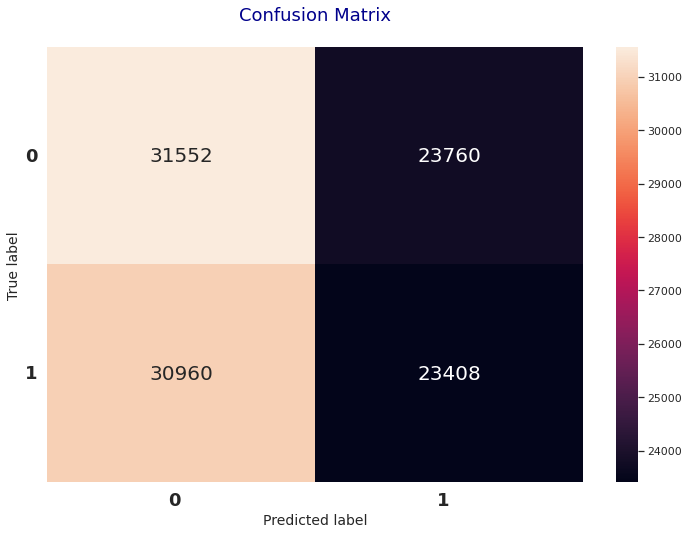

In [335]:
# Visualising confusion matrix
plt.figure(figsize = (12,8),facecolor='white')
# heatmap = sns.heatmap(c_matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap = sns.heatmap(c_matrix, annot = True, annot_kws = {'size': 20}, fmt = 'g')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

#Backtesting

In [336]:
df_bt = pd.DataFrame(bt, columns =['Value','GT','P'])

In [337]:
print(df_bt.head(5))
df_bt.info()

      Value   GT    P
0 -1.256597  1.0  0.0
1  0.171917  1.0  0.0
2  0.104940  1.0  0.0
3 -0.102065  1.0  0.0
4  0.033106  1.0  0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109680 entries, 0 to 109679
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Value   109680 non-null  float64
 1   GT      109680 non-null  float64
 2   P       109680 non-null  float64
dtypes: float64(3)
memory usage: 2.5 MB


In [338]:
test_df.loc[input_width-1:input_width-1+5]

,Spot,ch_return,Buy
239,17444.973028,-1.256597,1
240,17445.163294,0.171917,1
241,17445.279358,0.104940,1
242,17445.166088,-0.102065,1
243,17445.202570,0.033106,1
244,17444.716233,-0.438809,1


In [80]:
# df_bt['ch_return'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['ch_return']].reset_index(drop=True)
# df_bt['Spot'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Spot']].reset_index(drop=True)
# df_bt['Sell'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Sell']].reset_index(drop=True)
# df_bt['Buy'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Buy']].reset_index(drop=True)
# df_bt['Sell Hold'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Sell Hold']].reset_index(drop=True)
# df_bt['Buy Hold'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Buy Hold']].reset_index(drop=True)

In [339]:
df_bt['ch_return'] = test_df.loc[input_width-1:,['ch_return']].reset_index(drop=True)
df_bt['Spot'] = test_df.loc[input_width-1:,['Spot']].reset_index(drop=True)
df_bt['Buy'] = test_df.loc[input_width-1:,['Buy']].reset_index(drop=True)

In [340]:
df_bt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109680 entries, 0 to 109679
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Value      109680 non-null  float64
 1   GT         109680 non-null  float64
 2   P          109680 non-null  float64
 3   ch_return  109680 non-null  float64
 4   Spot       109680 non-null  float64
 5   Buy        109680 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 5.0 MB


In [341]:
print(df_bt.head(10))
print(df_bt.tail(20))
df_bt.info()

      Value   GT    P  ch_return          Spot  Buy
0 -1.256597  1.0  0.0  -1.256597  17444.973028    1
1  0.171917  1.0  0.0   0.171917  17445.163294    1
2  0.104940  1.0  0.0   0.104940  17445.279358    1
3 -0.102065  1.0  0.0  -0.102065  17445.166088    1
4  0.033106  1.0  0.0   0.033106  17445.202570    1
5 -0.438809  1.0  0.0  -0.438809  17444.716233    1
6  0.063195  1.0  0.0   0.063195  17444.786049    1
7  0.040748  1.0  0.0   0.040748  17444.830997    1
8 -0.567645  1.0  0.0  -0.567645  17444.201926    1
9  0.289252  1.0  0.0   0.289252  17444.522183    1
           Value   GT    P  ch_return          Spot  Buy
109660  0.009682  0.0  0.0   0.009682  17700.833548    0
109661 -0.030853  0.0  0.0  -0.030853  17700.799172    0
109662 -0.029138  0.0  0.0  -0.029138  17700.766695    0
109663 -0.134778  0.0  0.0  -0.134778  17700.617184    0
109664 -0.122493  0.0  1.0  -0.122493  17700.481283    0
109665 -0.049241  0.0  1.0  -0.049241  17700.426535    0
109666 -0.287892  0.0  1.0  -

In [ ]:
# df_bt_a = df_bt[['Spot','GT','P']]

###Agent

In [249]:
class Agent:
    def __init__(self, trend, prediction, initial_money):
      self.trend = trend
      self.prediction = prediction 
      self.inventory = []
      self.initial_money = initial_money

    def trade(self):
      starting_money = initial_money
      states_sell = []
      states_buy = []
      # inventory = [self.trend[0]]
      Money_inhand = [initial_money]
      position = [0]
      portfolio_value = [initial_money]
      last_traded_price = [0]
      if initial_money >= self.trend[0]:
        for t in range(1, len(self.trend)):            
          # print(t)

          if self.prediction[t] == 1 and position[t-1]<=0:
            states_buy.append(t)
            Money_inhand.append(Money_inhand[t-1]-self.trend[t])
            position.append(position[t-1] + 1)
            # portfolio_value.append(Money_inhand[t] + position[t]*self.trend[t])
            # inventory.append(self.trend[t])
            # print('time %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))                    

          elif self.prediction[t] == 0 and position[t-1]>0:
            states_sell.append(t)
            Money_inhand.append(Money_inhand[t-1]+self.trend[t])
            position.append(position[t-1] - 1)
            # portfolio_value.append(Money_inhand[t] + position[t]*self.trend[t])
            # bought_price = inventory.pop(0)
            # initial_money += self.trend[t]
            # try:
            #     invest = ((close[t] - bought_price) / bought_price) * 100
            # except:
            #     invest = 0
            # print(
            #     'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                # % (t, close[t], invest, initial_money)
            # )
          else:
            Money_inhand.append(Money_inhand[t-1])
            position.append(position[t-1])

          portfolio_value.append(Money_inhand[t] + position[t]*self.trend[t])
      
      print(position[t],Money_inhand[t],portfolio_value[t])

      if position[t]<0:
        print('Square off: Buy at the end', position[t])
        states_buy.append(t)
        Money_inhand[t] = Money_inhand[t] + position[t]*self.trend[t]

      if position[t]>0:
        print('Square off: Sell at the end', position[t])
        states_sell.append(t)
        Money_inhand[t] = Money_inhand[t] + position[t]*self.trend[t]

      print(Money_inhand[t],portfolio_value[t])
      # return states_buy, states_sell, total_gains, invest, len(inventory)
      return states_buy, states_sell, Money_inhand, position, portfolio_value

###Parameter

In [342]:
initial_money = 20000
trend = df_bt.Spot.values.tolist()
prediction = df_bt.P.values.tolist()
agent = Agent(trend, prediction, initial_money)
states_buy, states_sell, Money_inhand, position, portfolio_value = agent.trade()

1 2399.811658999919 20099.21527899992
Square off: Sell at the end 1
20099.21527899992 20099.21527899992


#Backtest visualization

##Portfolio

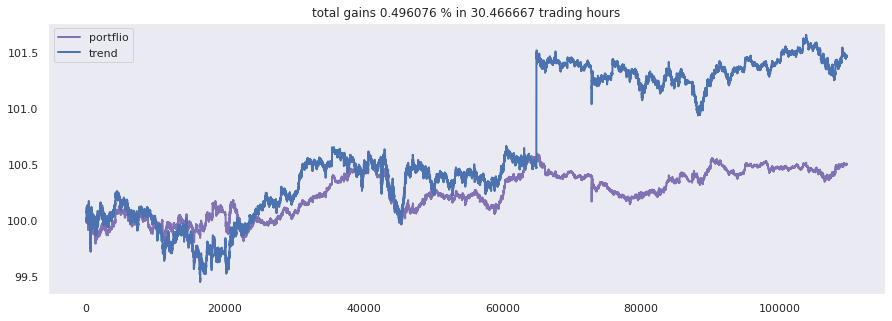

In [343]:
fig = plt.figure(figsize = (15,5))
portfolio_value[:] = [x / portfolio_value[0] * 100 for x in portfolio_value]
plt.plot(portfolio_value, color='m', label = 'portflio', lw=2.)
trend[:] = [x / trend[0] * 100 for x in trend]
plt.plot(trend, color='b', label = 'trend', lw=2.)
# plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
# plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f %% in %f trading hours'%(portfolio_value[-1]-100, len(trend)/3600))
plt.legend()
# plt.savefig(name+'.png')
plt.show()

##Trade signal

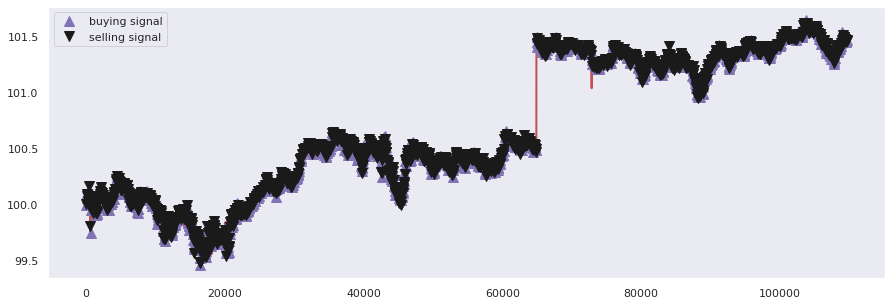

1728 1728


In [344]:
fig = plt.figure(figsize = (15,5))
plt.plot(trend, color='r', lw=2.)
plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig(name+'.png')
plt.show()
print(len(states_buy), len(states_sell))

##Position

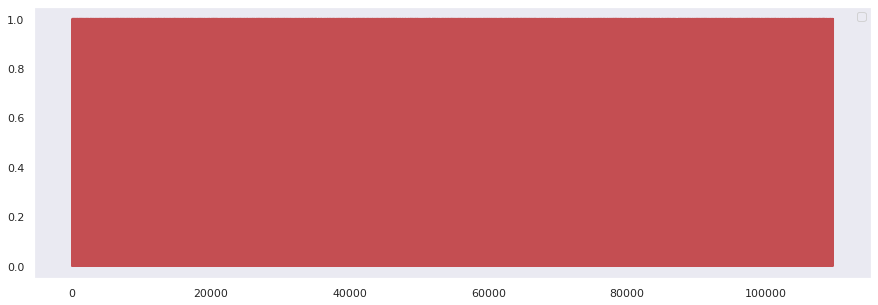

In [345]:
fig = plt.figure(figsize = (15,5))
plt.plot(position, color='r', lw=2.)
plt.legend()
plt.show()

#Results of validation dataset

In [400]:
n = len(val_df)-input_width
leng = n//batch_size
bt = np.zeros((batch_size*leng,3));
# print(np.shape(bt))
for n1 in tqdm(range(0, int((len(df)-240)*0.2/batch_size)-15)):
# for n1 in tqdm(range(0, int((len(df)-240)*0.2/batch_size)-13600)):
  temp_X = val_gen[n1][0]
  temp_y = val_gen[n1][1]
  yp1 = model.predict(temp_X, verbose=0)
  # print(np.shape(temp_X))
  bt[n1*batch_size:(n1+1)*batch_size,0] = temp_X[:,-1,0]
  # bt[n1*batch_size:(n1+1)*batch_size,1] = np.argmax(temp_y, axis = 1)
  bt[n1*batch_size:(n1+1)*batch_size,1] =round(temp_y[0][0])
  # bt[n1*batch_size:(n1+1)*batch_size,2] = np.argmax(yp1, axis = 1)
  bt[n1*batch_size:(n1+1)*batch_size,2] =yp1[0][0]
  # bt[n1*batch_size:(n1+1)*batch_size,2:] = yp1
  

100%|██████████| 13726/13726 [20:25<00:00, 11.20it/s]


In [401]:
bt_df = pd.DataFrame(bt[:,:(int((len(df)-240)*0.2/batch_size)-15)*batch_size])
bt = bt[0:(int((len(df)-240)*0.2/batch_size)-15)*batch_size,:]

In [402]:
bt[:,2][bt[:,2]<0.499] = 0
bt[:,2][bt[:,2]>=0.499] = 1

In [403]:
c_matrix = tf.math.confusion_matrix(bt[:,1],bt[:,2])

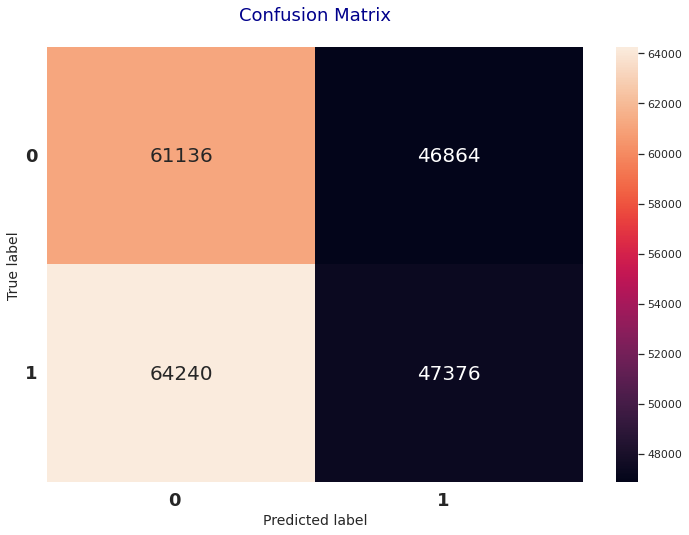

In [404]:
# Visualising confusion matrix
plt.figure(figsize = (12,8),facecolor='white')
# heatmap = sns.heatmap(c_matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap = sns.heatmap(c_matrix, annot = True, annot_kws = {'size': 20}, fmt = 'g')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

In [405]:
df_bt = pd.DataFrame(bt, columns =['Value','GT','P'])

In [406]:
print(df_bt.head(5))
df_bt.info()

      Value   GT    P
0 -0.654404  0.0  0.0
1  0.108681  0.0  0.0
2 -0.493670  0.0  0.0
3 -0.663044  0.0  0.0
4 -0.283058  0.0  0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219616 entries, 0 to 219615
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Value   219616 non-null  float64
 1   GT      219616 non-null  float64
 2   P       219616 non-null  float64
dtypes: float64(3)
memory usage: 5.0 MB


In [384]:
# df_bt['ch_return'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['ch_return']].reset_index(drop=True)
# df_bt['Spot'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Spot']].reset_index(drop=True)
# df_bt['Sell'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Sell']].reset_index(drop=True)
# df_bt['Buy'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Buy']].reset_index(drop=True)
# df_bt['Sell Hold'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Sell Hold']].reset_index(drop=True)
# df_bt['Buy Hold'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Buy Hold']].reset_index(drop=True)

In [410]:
df_bt['ch_return'] = val_df.loc[input_width-1:,['ch_return']].reset_index(drop=True)
df_bt['Spot'] = val_df.loc[input_width-1:,['Spot']].reset_index(drop=True)
df_bt['Buy'] = val_df.loc[input_width-1:,['Buy']].reset_index(drop=True)

In [411]:
df_bt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219616 entries, 0 to 219615
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Value      219616 non-null  float64
 1   GT         219616 non-null  float64
 2   P          219616 non-null  float64
 3   ch_return  219616 non-null  float64
 4   Spot       219616 non-null  float64
 5   Buy        219616 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 10.1 MB


In [412]:
print(df_bt.head(10))
print(df_bt.tail(20))
df_bt.info()

      Value   GT    P  ch_return          Spot  Buy
0 -0.654404  0.0  0.0  -0.654404  16627.870508    0
1  0.108681  0.0  0.0   0.108681  16627.990717    0
2 -0.493670  0.0  0.0  -0.493670  16627.443601    1
3 -0.663044  0.0  0.0  -0.663044  16626.708841    1
4 -0.283058  0.0  0.0  -0.283058  16626.395055    1
5 -0.382442  0.0  0.0  -0.382442  16625.971165    1
6 -0.704879  0.0  0.0  -0.704879  16625.190058    1
7  0.138831  0.0  0.0   0.138831  16625.343669    1
8  0.121489  0.0  0.0   0.121489  16625.478067    1
9  0.274314  0.0  0.0   0.274314  16625.781775    1
           Value   GT    P  ch_return          Spot  Buy
219596  0.743903  0.0  1.0   0.743903  17439.191978    0
219597  0.168475  0.0  1.0   0.168475  17439.378430    0
219598  0.360150  0.0  1.0   0.360150  17439.777233    0
219599 -1.171610  0.0  1.0  -1.171610  17438.479050    0
219600  0.555648  0.0  0.0   0.555648  17439.094439    0
219601  0.089364  0.0  0.0   0.089364  17439.193247    0
219602 -0.262930  0.0  0.0  -

In [419]:
trend = df_bt.Spot.values.tolist()
initial_money = df_bt.Spot.values.tolist()[0]
print(initial_money)
prediction = df_bt.P.values.tolist()
agent = Agent(trend, prediction, initial_money)
states_buy, states_sell, Money_inhand, position, portfolio_value = agent.trade()

16627.870508
0 16895.79259500004 16895.79259500004
16895.79259500004 16895.79259500004


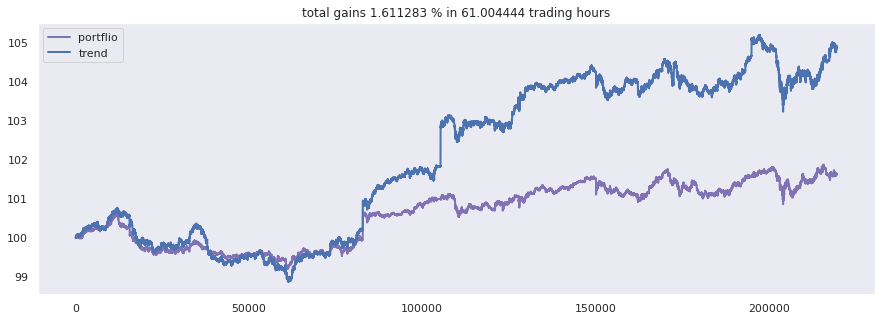

In [420]:
fig = plt.figure(figsize = (15,5))
portfolio_value[:] = [x / portfolio_value[0] * 100 for x in portfolio_value]
plt.plot(portfolio_value, color='m', label = 'portflio', lw=2.)
trend[:] = [x / trend[0] * 100 for x in trend]
plt.plot(trend, color='b', label = 'trend', lw=2.)
# plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
# plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f %% in %f trading hours'%(portfolio_value[-1]-100, len(trend)/3600))
plt.legend()
# plt.savefig(name+'.png')
plt.show()

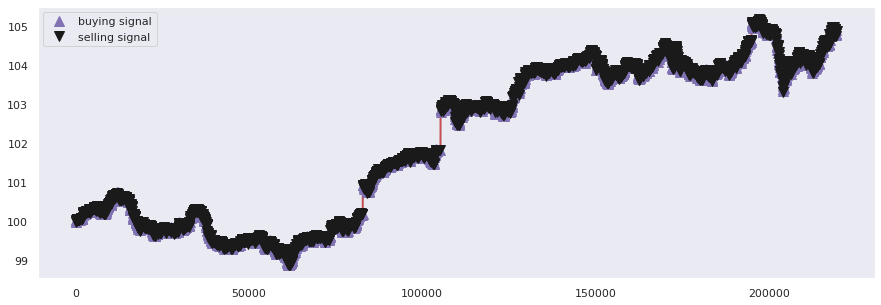

3409 3409


In [415]:
fig = plt.figure(figsize = (15,5))
plt.plot(trend, color='r', lw=2.)
plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig(name+'.png')
plt.show()
print(len(states_buy), len(states_sell))

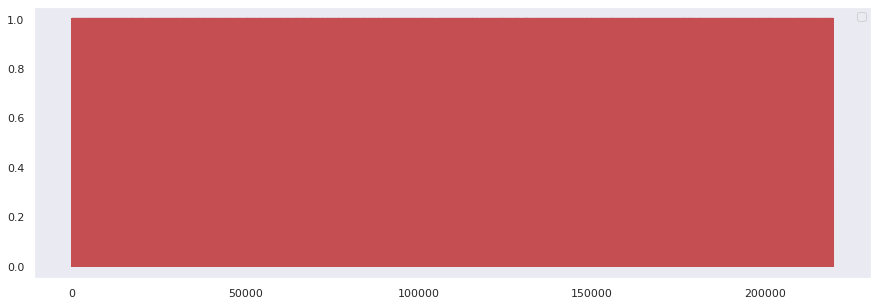

In [416]:
fig = plt.figure(figsize = (15,5))
plt.plot(position, color='r', lw=2.)
plt.legend()
plt.show()

#Results of training dataset

In [449]:
n = len(val_df)-input_width
leng = n//batch_size
bt = np.zeros((batch_size*leng,3));
# print(np.shape(bt))
for n1 in tqdm(range(0, int((len(df)-240)*0.7/batch_size)-40000)):
# for n1 in tqdm(range(0, int((len(df)-240)*0.7/batch_size)-47600)):
  temp_X = val_gen[n1][0]
  temp_y = val_gen[n1][1]
  yp1 = model.predict(temp_X, verbose=0)
  # print(np.shape(temp_X))
  bt[n1*batch_size:(n1+1)*batch_size,0] = temp_X[:,-1,0]
  # bt[n1*batch_size:(n1+1)*batch_size,1] = np.argmax(temp_y, axis = 1)
  bt[n1*batch_size:(n1+1)*batch_size,1] =round(temp_y[0][0])
  # bt[n1*batch_size:(n1+1)*batch_size,2] = np.argmax(yp1, axis = 1)
  bt[n1*batch_size:(n1+1)*batch_size,2] =yp1[0][0]
  # bt[n1*batch_size:(n1+1)*batch_size,2:] = yp1
  

100%|██████████| 8094/8094 [11:53<00:00, 11.34it/s]


In [450]:
bt_df = pd.DataFrame(bt[:,:(int((len(df)-240)*0.7/batch_size)-40000)*batch_size])
bt = bt[0:(int((len(df)-240)*0.7/batch_size)-40000)*batch_size,:]

In [451]:
bt[:,2][bt[:,2]<0.499] = 0
bt[:,2][bt[:,2]>=0.499] = 1

In [452]:
c_matrix = tf.math.confusion_matrix(bt[:,1],bt[:,2])

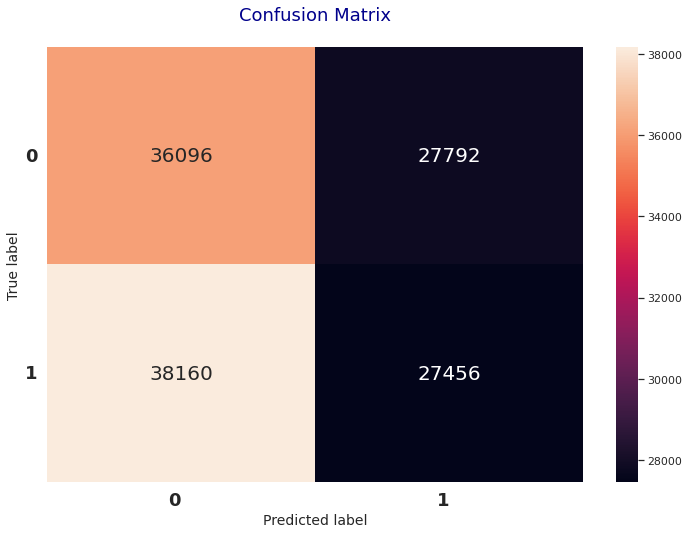

In [453]:
# Visualising confusion matrix
plt.figure(figsize = (12,8),facecolor='white')
# heatmap = sns.heatmap(c_matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap = sns.heatmap(c_matrix, annot = True, annot_kws = {'size': 20}, fmt = 'g')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

In [454]:
df_bt = pd.DataFrame(bt, columns =['Value','GT','P'])

In [455]:
print(df_bt.head(5))
df_bt.info()

      Value   GT    P
0 -0.654404  0.0  0.0
1  0.108681  0.0  0.0
2 -0.493670  0.0  0.0
3 -0.663044  0.0  0.0
4 -0.283058  0.0  0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129504 entries, 0 to 129503
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Value   129504 non-null  float64
 1   GT      129504 non-null  float64
 2   P       129504 non-null  float64
dtypes: float64(3)
memory usage: 3.0 MB


In [ ]:
# df_bt['ch_return'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['ch_return']].reset_index(drop=True)
# df_bt['Spot'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Spot']].reset_index(drop=True)
# df_bt['Sell'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Sell']].reset_index(drop=True)
# df_bt['Buy'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Buy']].reset_index(drop=True)
# df_bt['Sell Hold'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Sell Hold']].reset_index(drop=True)
# df_bt['Buy Hold'] = test_df.loc[input_width-1:input_width-1+int((len(test_df)-input_width)/(batch_size))*batch_size,['Buy Hold']].reset_index(drop=True)

In [456]:
df_bt['ch_return'] = train_df.loc[input_width-1:,['ch_return']].reset_index(drop=True)
df_bt['Spot'] = train_df.loc[input_width-1:,['Spot']].reset_index(drop=True)
df_bt['Buy'] = train_df.loc[input_width-1:,['Buy']].reset_index(drop=True)

In [457]:
df_bt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129504 entries, 0 to 129503
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Value      129504 non-null  float64
 1   GT         129504 non-null  float64
 2   P          129504 non-null  float64
 3   ch_return  129504 non-null  float64
 4   Spot       129504 non-null  float64
 5   Buy        129504 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 5.9 MB


In [458]:
print(df_bt.head(10))
print(df_bt.tail(20))
df_bt.info()

      Value   GT    P  ch_return          Spot  Buy
0 -0.654404  0.0  0.0  -1.010357  16774.241739    1
1  0.108681  0.0  0.0  -0.421520  16773.774556    1
2 -0.493670  0.0  0.0   0.049236  16773.828908    1
3 -0.663044  0.0  0.0  -0.175281  16773.634525    1
4 -0.283058  0.0  0.0   1.767767  16775.592780    1
5 -0.382442  0.0  0.0  -0.005074  16775.586963    1
6 -0.704879  0.0  0.0   0.433849  16776.067414    1
7  0.138831  0.0  0.0  -0.825974  16775.152149    1
8  0.121489  0.0  0.0   0.239462  16775.417246    1
9  0.274314  0.0  0.0   0.192225  16775.630010    1
           Value   GT    P  ch_return          Spot  Buy
129484  0.244681  1.0  1.0  -0.412673  16196.532906    1
129485 -0.373579  1.0  1.0  -0.897707  16195.538171    1
129486  0.263423  1.0  1.0  -0.518950  16194.963048    1
129487 -0.060504  1.0  1.0   0.234280  16195.222404    1
129488 -0.303229  0.0  0.0  -0.356608  16194.827134    1
129489  0.074661  0.0  0.0  -0.228143  16194.574186    1
129490 -0.378403  0.0  0.0  -

In [459]:
trend = df_bt.Spot.values.tolist()
initial_money = df_bt.Spot.values.tolist()[0]
print(initial_money)
prediction = df_bt.P.values.tolist()
agent = Agent(trend, prediction, initial_money)
states_buy, states_sell, Money_inhand, position, portfolio_value = agent.trade()

16774.241739
0 16335.592745000007 16335.592745000007
16335.592745000007 16335.592745000007


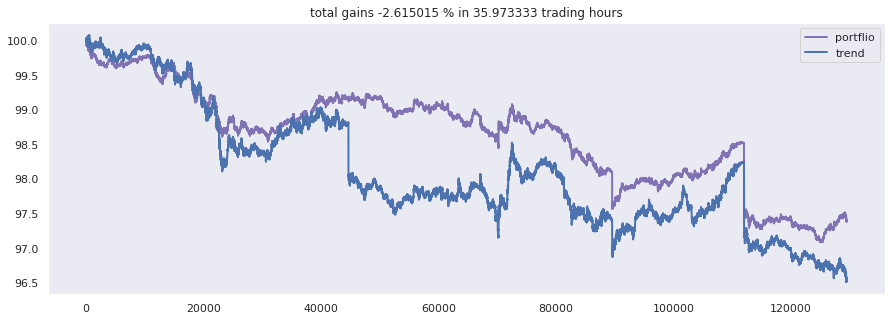

In [460]:
fig = plt.figure(figsize = (15,5))
portfolio_value[:] = [x / portfolio_value[0] * 100 for x in portfolio_value]
plt.plot(portfolio_value, color='m', label = 'portflio', lw=2.)
trend[:] = [x / trend[0] * 100 for x in trend]
plt.plot(trend, color='b', label = 'trend', lw=2.)
# plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
# plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f %% in %f trading hours'%(portfolio_value[-1]-100, len(trend)/3600))
plt.legend()
# plt.savefig(name+'.png')
plt.show()

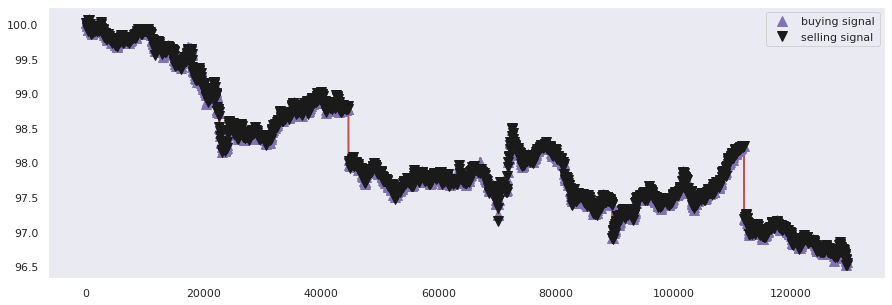

1997 1997


In [461]:
fig = plt.figure(figsize = (15,5))
plt.plot(trend, color='r', lw=2.)
plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig(name+'.png')
plt.show()
print(len(states_buy), len(states_sell))

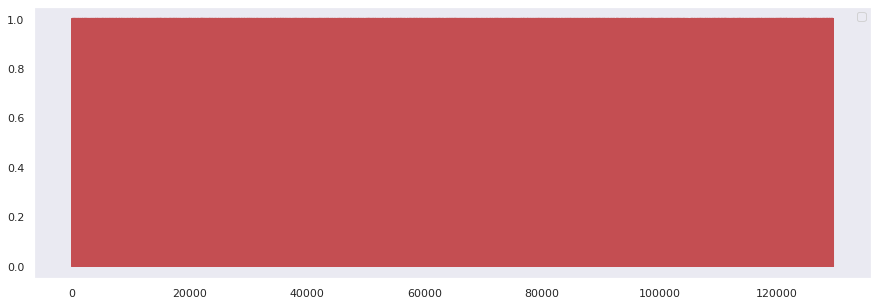

In [462]:
fig = plt.figure(figsize = (15,5))
plt.plot(position, color='r', lw=2.)
plt.legend()
plt.show()